<a href="https://colab.research.google.com/github/rodrigorcarmo/multi_agent_chatbot/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis
### This notebook contains some analysis of the provided dataset and a model to correctly identify sentiments by using external data

In [1]:
! pip install nltk tensorflow datasets wordcloud skops transformers

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00


In [3]:
# import libraries
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
import nltk
nltk.download(['punkt','wordnet','stopwords'])

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/Customer_Feedback_Dataset.csv',sep=';')
df.head(5)

,feedback_id,customer_id,feedback_text,feedback_category,date,sentiment,response_required,response_time,resolved
0,1,4174,Excellent value for money!,Product Quality,2023-06-05,positive,Yes,15.0,Yes
1,2,4507,Not satisfied with the service.,Product Quality,2023-10-02,positive,No,29.0,No
2,3,1860,The pricing is too high for what you get.,Delivery,2023-08-10,positive,Yes,NaN,No
3,4,2294,"Great product, but the delivery was late.",Pricing,2023-03-04,neutral,No,NaN,No
4,5,2130,The delivery was fast and the product is good.,Delivery,2023-06-22,positive,Yes,NaN,No


In [4]:
# Evaluating the distribution of sentiments within the dataset
df['sentiment'].value_counts()

,count
sentiment,
positive,356
neutral,338
negative,306


In [5]:
# Looking at a sample of texts for each category and there is clearly mislabeled texts
df.groupby('sentiment')['feedback_text'].apply(lambda x: x.sample(5))

sentiment     
negative   754                       I had issues with the website.
           197                           Excellent value for money!
           337    The quality of the product was below expectati...
           75             Great product, but the delivery was late.
           551                      Not satisfied with the service.
neutral    453               The customer service was very helpful.
           930                       I had issues with the website.
           916               The customer service was very helpful.
           946                           Excellent value for money!
           167              Easy to use website and quick checkout.
positive   163            Great product, but the delivery was late.
           687                       I had issues with the website.
           457       The delivery was fast and the product is good.
           202            The pricing is too high for what you get.
           267                           Excellent value for money!
Name: feedback_text, dtype: object

In [6]:
# Since there was an impression of mislabeled data, aggregating the feedbacks by their sentiment labels shows the same text being classified for all labels
df.groupby(['feedback_text','sentiment']).agg({'feedback_id':'count'}).reset_index().pivot_table(index='feedback_text', columns='sentiment', values='feedback_id')

sentiment,negative,neutral,positive
feedback_text,,,
Easy to use website and quick checkout.,24.0,33.0,38.0
Excellent value for money!,30.0,37.0,35.0
"Great product, but the delivery was late.",41.0,36.0,39.0
I had issues with the website.,23.0,37.0,40.0
Not satisfied with the service.,35.0,28.0,27.0
Received a defective item.,23.0,34.0,40.0
The customer service was very helpful.,34.0,34.0,36.0
The delivery was fast and the product is good.,45.0,29.0,31.0
The pricing is too high for what you get.,30.0,36.0,42.0


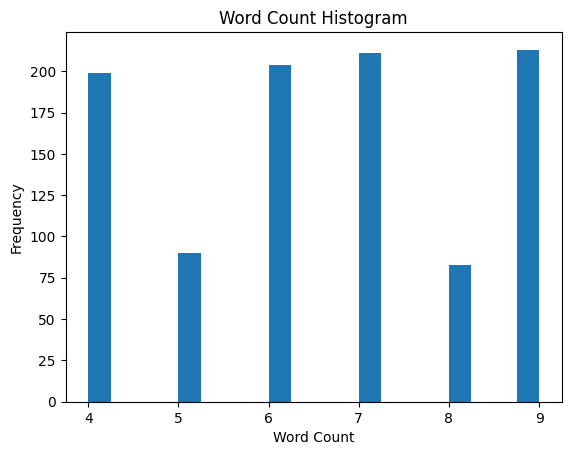

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate word counts for each feedback text
df['word_count'] = df['feedback_text'].apply(lambda x: len(str(x).split()))

# Create a histogram of word counts to show that the dataset is composed of small texts
plt.hist(df['word_count'], bins=20)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Histogram')
plt.show()

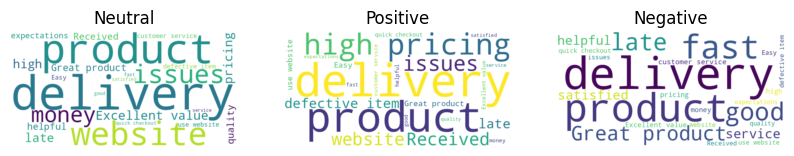

In [10]:
from wordcloud import WordCloud

# Plotting some wordclouds to get a better analysis of most common words for each label
neutral_text = ' '.join(df[df['sentiment'] == 'neutral']['feedback_text'])
positive_text = ' '.join(df[df['sentiment'] == 'positive']['feedback_text'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['feedback_text'])

neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral')
plt.subplot(1, 3, 2)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive')
plt.subplot(1, 3, 3)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative')
plt.show()

In [11]:
# Using a public dataset with small texts to create a sentiment analysis model to use on the dataset as the provided labels are not reliable
# The dataset is a Twitter database labeled with positive and negative sentiment for each tweet
url='https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
!wget {url}
!unzip trainingandtestdata.zip

--2024-10-15 01:27:32--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M   442KB/s    in 4m 21s  

2024-10-15 01:31:53 (305 KB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [12]:
# Loading the data
cols = ['sentiment','id','date','query_string','user','text']
df_train = pd.read_csv('training.1600000.processed.noemoticon.csv',
                        header=None, names=cols,encoding="latin-1")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1600000 non-null  int64 
 1   id            1600000 non-null  int64 
 2   date          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   user          1600000 non-null  object
 5   text          1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [13]:
df_train.head(2)

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [14]:
# Evaluating the distribution of the labels on the dataset, 0 stands for negative and 4 for positive tweets
df_train['sentiment'].value_counts()

,count
sentiment,
0,800000
4,800000


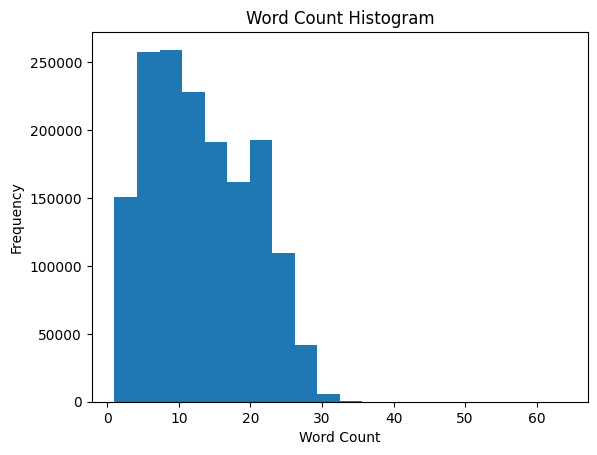

In [15]:
# Calculate word counts for each tweet
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

# Create a histogram of word counts to show that the dataset is composed of small texts just like the customer feedbacks
plt.hist(df_train['word_count'], bins=20)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Histogram')
plt.show()

In [16]:
# The approach will be to train a classifier on new data in order to correctly associate labels
# First, creating a function to preprocess the text
def preprocess_text(text):
    # Converting to lowercase
    text = text.lower()

    # Removing punctuation, numbers, special characters, user's mentions that start with "@..." and links
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [17]:
df_train['processed_text'] = df_train['text'].apply(preprocess_text)

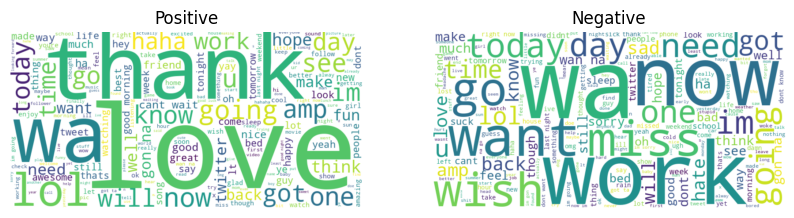

In [18]:
# Plotting some wordclouds to get a better analysis of most common words for each label
positive_text = ' '.join(df_train[df_train['sentiment'] == 4]['processed_text'])
negative_text = ' '.join(df_train[df_train['sentiment'] == 0]['processed_text'])

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive')
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import joblib

# Getting the TF-IDF representation
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

# Train and test split
X_train, X_val, y_train, y_val = train_test_split(df_train['processed_text'], df_train['sentiment'], test_size=0.3, random_state=23)

# Creating a Sklearn pipeline to automatically process the text into the TF-IDF matrix and passing it to the classifier
pipe = Pipeline([('vectorizer', vectorizer), ('mnb', MultinomialNB())])

pipe.fit(X_train, y_train)
predicted = pipe.predict(X_val)
print(metrics.classification_report(y_val, predicted))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80    240065
           4       0.81      0.79      0.80    239935

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000



In [20]:
# The classifer gets an overall good performance on the validation dataset, now evaluating its performance on the test dataset

In [21]:
df_test = pd.read_csv('testdata.manual.2009.06.14.csv',
                        header=None, names=cols,encoding="latin-1")
df_test['processed_text'] = df_test['text'].apply(preprocess_text)
df_test = df_test[df_test['sentiment']!=2]
df_test.head(2)

,sentiment,id,date,query_string,user,text,processed_text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,i loooooooovvvvvveee my kindle not that the dx...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...,reading my kindle love it lee child is good read


In [22]:
predicted = pipe.predict(df_test['processed_text'].tolist())
print(metrics.classification_report(df_test['sentiment'], predicted))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       177
           4       0.83      0.86      0.84       182

    accuracy                           0.84       359
   macro avg       0.84      0.84      0.84       359
weighted avg       0.84      0.84      0.84       359



In [24]:
# The classifier overall achieves a good perfomance also, therefore it is a good canditate do be used on the customer dataset

In [23]:
# Saving the pipeline to be reused
joblib.dump(pipe, 'pipeline_sentiment_analysis.pkl')

['pipeline_sentiment_analysis.pkl']

#### The ideia is to build a multi agent system with Langchain. Since I am going the use the HuggingFace library to perform other actions, I will upload this model there in order to make it more easily reusable

In [25]:
from skops import card, hub_utils
import pickle
import sklearn
from pathlib import Path

In [26]:
local_repo = "ia_collab_sentiment_model"
hub_utils.init(
    model='pipeline_sentiment_analysis.pkl',
    requirements=[f"scikit-learn={sklearn.__version__}"],
    dst=local_repo,
    task="text-classification",
    data=df_test['processed_text'].tolist(),
)

In [27]:
model_card = card.Card(pipe, metadata=card.metadata_from_config(Path(local_repo)))

In [28]:
model_card.metadata.license = "mit"
limitations = "This pipeline is for studying purposes only."
model_description = (
    "This is a pipeline for sentiment analysis trained on the Stanford Twitter dataset."
    "TF-IDF vectorizer is used for vectorization."
)
model_card_authors = "Rodrigo Rodrigues do Carmo"
get_started_code = (
    "import joblib\nmodel = joblib.load('pipeline_sentiment_analysis.pkl')"
)
model_card.add(
    get_started_code=get_started_code,
    model_card_authors=model_card_authors,
    limitations=limitations,
)
model_card.add(**{"Model description": f"{model_description}"})

Card(
  model=Pipeline(steps=[('vectorizer', Tfi...=True)), ('mnb', MultinomialNB())]),
  metadata.library_name=sklearn,
  metadata.license=mit,
  metadata.tags=['sklearn', 'skops', 'text-classification'],
  metadata.model_format=pickle,
  metadata.model_file=pipeline_sentiment_analysis.pkl,
  Model description=This is a pipeline for senti...er is used for vectorization.,
  Model description/Training Procedure/Hyperparameters=TableSection(30x2),
  Model description/Training Procedure/Model Plot=<style>#sk-co...v></div></div>,
  get_started_code=import joblib model = joblib....line_sentiment_analysis.pkl'),
  model_card_authors=Rodrigo Rodrigues do Carmo,
  limitations=This pipeline is for studying purposes only.,
)

In [29]:
model_card.save(Path(local_repo) / "README.md")

In [ ]:
repo_id = "rodrigorcarmo/ia_collab_sentiment"
hub_utils.push(
    repo_id=repo_id,
    source=local_repo,
    token='<HuggigFace API Token>',
    commit_message="feat: uploading the sklearn pipeline",
    create_remote=True,
)

/usr/local/lib/python3.10/dist-packages/skops/hub_utils/_hf_hub.py:551: FutureWarning: Creating repos on hf.co is subject to strict rate limits now and therefore this feature is to be removed from this library in version 0.10. You can use tools directly available in the huggingface_hub library instead to create and push files.
  warnings.warn(


#### Now using the classifer on the customer dataset to evaluate its performance

In [30]:
df['processed_text'] = df['feedback_text'].apply(preprocess_text)
df['sentiment_pred'] = pipe.predict(df['processed_text'].tolist())
df['sentiment_pred_label'] = df['sentiment_pred'].map({ 0: 'negative', 4 : 'positive'})
df.head(2)

,feedback_id,customer_id,feedback_text,feedback_category,date,sentiment,response_required,response_time,resolved,word_count,processed_text,sentiment_pred,sentiment_pred_label
0,1,4174,Excellent value for money!,Product Quality,2023-06-05,positive,Yes,15.0,Yes,4,excellent value for money,4,positive
1,2,4507,Not satisfied with the service.,Product Quality,2023-10-02,positive,No,29.0,No,5,not satisfied with the service,4,positive


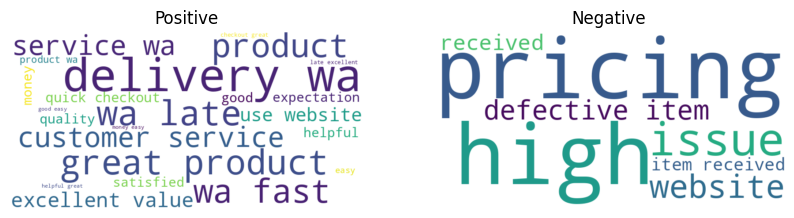

In [31]:
# Plotting some wordclouds to get a better analysis of most common words for each label
positive_text = ' '.join(df[df['sentiment_pred_label'] == 'positive']['processed_text'])
negative_text = ' '.join(df[df['sentiment_pred_label'] == 'negative']['processed_text'])

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive')
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative')
plt.show()

In [32]:
# Evaluating the same distribution with the new labels
df.groupby(['feedback_text','sentiment_pred_label']).agg({'feedback_id':'count'}).reset_index().pivot_table(index='feedback_text', columns='sentiment_pred_label', values='feedback_id')

sentiment_pred_label,negative,positive
feedback_text,,
Easy to use website and quick checkout.,NaN,95.0
Excellent value for money!,NaN,102.0
"Great product, but the delivery was late.",NaN,116.0
I had issues with the website.,100.0,NaN
Not satisfied with the service.,NaN,90.0
Received a defective item.,97.0,NaN
The customer service was very helpful.,NaN,104.0
The delivery was fast and the product is good.,NaN,105.0
The pricing is too high for what you get.,108.0,NaN


Conclusion: the classifer does a better job evaluationg the sentiments of the customers, with the texts being assigned to one label and it does make sense. Therefore, it is the classifier to be used on the Multi Agent System